### Explore the effect of parasitemia on assay performance

In [24]:
import pandas as pd
import numpy as np
from nomadic.lib.parsing import build_parameter_dict
from nomadic.pipeline.qcbams.plot import MappingStatesAndColors

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 100

### Define an experiment

In [197]:
class Experiment:
    
    mapping_levels = ["pf_mapped", "hs_mapped", "unmapped"]
    thresh = 100
    focus_columns = ["barcode", 
                     "sample_id", 
                     "parasites_per_ul",
                     "parasites_per_ul_log10",
                     "per_pf_mapped",
                     "per_hs_mapped",
                     "n_reads",
                     "n_reads_log10",
                     "imb_factor",
                     "imb_factor_log10",
                     "n_reads_ontarget_total",
                     "n_reads_ontarget_total_log10",
                     "n_reads_ontarget_mean",
                     "n_reads_ontarget_mean_log10",
                     "n_targets",
                     f"n_targets_gr{thresh}"
                    ]
    
    def __init__(self, expt_dir):
        """
        Co-ordinate metadata, mapping and balance data for a single
        NOMADS nanopore experiment
        
        """
        # Define directories
        self.expt_dir = expt_dir
        self.nomadic_dir = f"{expt_dir}/nomadic/guppy/hac/single_end/"
        
        # Define paths
        self.metadata_path = f"{expt_dir}/metadata/sample_info.csv"
        self.mapping_path = f"{self.nomadic_dir}/qc-bams/table.mapping.primary_state.csv"
        self.extraction_path = f"{self.nomadic_dir}/target-extraction/table.target_coverage.overview.csv"
        
        
    def _load_metadata(self):
        """ Load metadata """
        
        self.metadata = pd.read_csv(self.metadata_path)
        
        
    def _load_mapping(self):
        """ Load mapping data """
        
        # LOAD
        self.mapping_df = pd.read_csv(self.mapping_path)
        
        # SUMMARY STATISTICS
        # No. reads
        self.mapping_df.insert(4, "n_reads", self.mapping_df[self.mapping_levels].sum(1))
        self.mapping_df.insert(5, "n_reads_log10", np.log10(self.mapping_df["n_reads"] + 1))
        
        # Percentages
        for i, mapping_level in enumerate(self.mapping_levels):
            self.mapping_df.insert(
                6+i,
                f"per_{mapping_level}",
                100*self.mapping_df[mapping_level]/self.mapping_df["n_reads"]
            )
        self.mapping_df.insert(
            self.mapping_df.shape[1], 
            "parasites_per_ul_log10",
            np.log10(self.mapping_df["parasites_per_ul"])
        )
        
        
    def _load_balance(self):
        """ 
        Load balance data 
        
        TODO:
        - Compute median coverage?
        
        """
        
        # LOAD
        self.extraction_df = pd.read_csv(self.extraction_path)
        
        # RESHAPE
        self.balance_df = pd.pivot_table(
            data=expt.extraction_df.query("overlap == 'any'"),
            values="reads_mapped",
            index="sample_id",
            columns="gene_name"
        )
        
        # SUMMARY STATISTICS
        # Ontarget
        n_ontarget_total = self.balance_df.sum(1)
        n_ontarget_mean = self.balance_df.mean(1)
        
        # Imbalance factor
        min_ontarget = self.balance_df.min(1)
        max_ontarget = self.balance_df.max(1)
        imb_factor = max_ontarget / (min_ontarget + 1)
        
        # Above threshold
        n_targets = self.balance_df.shape[1]
        targets_abv_thresh = self.balance_df.apply(lambda x: (x > self.thresh).sum(), axis=1)
        
        # Store
        self.balance_df.insert(self.balance_df.shape[1], "n_reads_ontarget_total", n_ontarget_total)
        self.balance_df.insert(self.balance_df.shape[1], "n_reads_ontarget_total_log10", np.log10(n_ontarget_total))
        self.balance_df.insert(self.balance_df.shape[1], "n_reads_ontarget_mean", n_ontarget_mean)
        self.balance_df.insert(self.balance_df.shape[1], "n_reads_ontarget_mean_log10", np.log10(n_ontarget_mean))
        self.balance_df.insert(self.balance_df.shape[1], "imb_factor", imb_factor)
        self.balance_df.insert(self.balance_df.shape[1], "imb_factor_log10", np.log10(imb_factor))
        self.balance_df.insert(self.balance_df.shape[1], "n_targets", n_targets)
        self.balance_df.insert(self.balance_df.shape[1], f"n_targets_gr{self.thresh}", targets_abv_thresh)
        
    
    def _merge_dfs(self):
        """ 
        Merge metadata, mapping data, and balance data 
        
        """
        n_barcodes = self.metadata.shape[0]
        assert self.balance_df.shape[0] == n_barcodes
        assert self.mapping_df.shape[0] == n_barcodes
        
        self.merged_df = pd.merge(
            left=self.mapping_df,
            right=self.balance_df,
            on="sample_id",
            how="inner"
        )
        
        assert self.merged_df.shape[0] == n_barcodes
    
    
    def load_data(self):
        """ Load all data and merge """
        
        self._load_metadata()
        self._load_mapping()
        self._load_balance()
        self._merge_dfs()
        
    
    def get_focus_df(self):
        """ Return dataframe with only column of interest """
        
        return self.merged_df[self.focus_columns]

        

### Load and aggregate across experiments

In [198]:
expt_dirs = [
    "../experiments/2021-11-14_strain-validation-flongle-lfb",
    "../experiments/2021-11-20_strain-validation-16plex/",
    "../experiments/2022-03-15_large-lab-validation-r1/"
]
expts = [Experiment(expt_dir) for expt_dir in expt_dirs]

In [199]:
dfs = []
for j, expt_dir in enumerate(expt_dirs):
    expt = Experiment(expt_dir)
    expt.load_data()
    df = expt.get_focus_df()
    df.insert(0, "expt_name", expt_dir)
    df.insert(0, "expt_ix", j)
    dfs.append(df)
final_df = pd.concat(dfs)

/Users/jasongms/opt/anaconda3/envs/nomadic2/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Summarise

In [200]:
final_df.groupby("parasites_per_ul").median()

,expt_ix,parasites_per_ul_log10,per_pf_mapped,per_hs_mapped,n_reads,n_reads_log10,imb_factor,imb_factor_log10,n_reads_ontarget_total,n_reads_ontarget_total_log10,n_reads_ontarget_mean,n_reads_ontarget_mean_log10,n_targets,n_targets_gr100
parasites_per_ul,,,,,,,,,,,,,,
0,2.0,-inf,77.436809,21.783889,855.5,2.929149,107.000000,2.029213,595.5,2.768981,37.21875,1.564861,16.0,1.0
10,0.5,1.00000,15.983869,83.855616,9299.0,3.954692,488.357143,2.520436,1298.0,3.113108,122.81250,2.059503,12.0,2.0
50,2.0,1.69897,28.174461,71.646135,17297.0,4.237996,228.000000,2.357935,3663.0,3.563837,265.00000,2.423246,16.0,8.0
100,2.0,2.00000,39.190555,60.681806,17489.0,4.242790,254.600000,2.405858,6597.0,3.819346,412.31250,2.615227,16.0,10.0
250,2.0,2.39794,61.634486,38.046700,22270.0,4.347740,250.875000,2.399457,12793.0,4.106972,799.56250,2.902852,16.0,12.0
500,2.0,2.69897,68.520508,31.356168,25137.0,4.400331,336.277778,2.526698,16306.0,4.212347,1019.12500,3.008227,16.0,12.0
1000,2.0,3.00000,63.557004,36.349070,22362.0,4.349530,350.062500,2.544146,10183.0,4.007876,698.25000,2.844011,16.0,11.0
2500,2.0,3.39794,78.481590,21.431014,22752.0,4.357039,314.600000,2.497759,17480.0,4.242541,1092.50000,3.038421,16.0,13.0
5000,2.0,3.69897,84.427926,15.487392,18385.0,4.264487,217.421053,2.337302,13988.0,4.145756,874.25000,2.941636,16.0,12.0


### Plot

- I could do two panels, one for 8plex and one for 16plex

In [228]:
class ParasitemiaPlotter:
    
    x = "parasites_per_ul_log10"
    xname = "Parasitemia (p/uL) [log10]"
    as_title = True
    
    
    def __init__(self, data):
        self.data = data
        
        
    def plot(self, ax, y, yname, **kwargs):
        
        # Plot
        ax.scatter(
            x=self.x,
            y=y,
            data=self.data,
            **kwargs
        )
        
        # Labels
        ax.set_xlabel(self.xname)
        if self.as_title:
            ax.set_title(yname, loc="left")
        else:
            ax.set_ylabel(yname)
        
        # Grid
        ax.set_axisbelow(True)
        ax.grid(ls='dotted')

In [229]:
final_df.columns

Index(['expt_ix', 'expt_name', 'barcode', 'sample_id', 'parasites_per_ul',
       'parasites_per_ul_log10', 'per_pf_mapped', 'per_hs_mapped', 'n_reads',
       'n_reads_log10', 'imb_factor', 'imb_factor_log10',
       'n_reads_ontarget_total', 'n_reads_ontarget_total_log10',
       'n_reads_ontarget_mean', 'n_reads_ontarget_mean_log10', 'n_targets',
       'n_targets_gr100'],
      dtype='object')

In [235]:
stats = {
    "n_reads_log10": "Total No. Reads [log10]",
    "per_pf_mapped": "P.f. Mapping (%)",
    "n_reads_ontarget_mean_log10": "Mean No. Reads\nper Target [log10]",
    "imb_factor_log10": "Imbalance Factor [log10]"
}

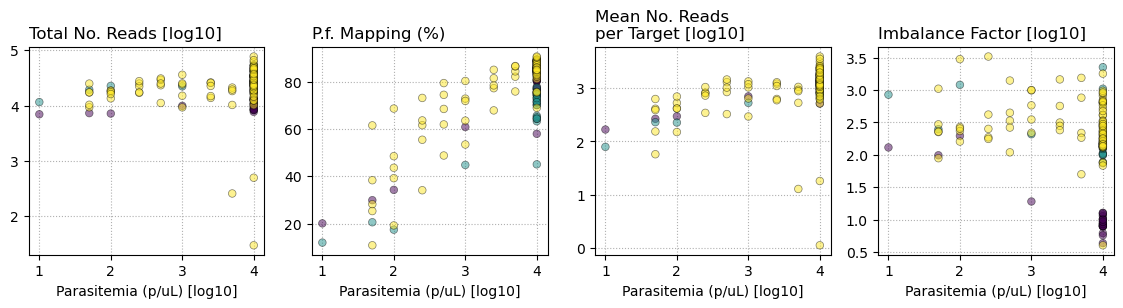

In [236]:
fig, axes = plt.subplots(1, len(stats), figsize=(len(stats)*3.5, 2.75))
fig.subplots_adjust(wspace=0.2)

# Set plotter
plotter = ParasitemiaPlotter(final_df)
plotter.as_title = True

# Iterate over statistics
for ax, (y, yname) in zip(axes.flatten(), stats.items()):
    
    # PLOT
    plotter.plot(
        ax=ax, 
        y=y, 
        yname=yname,
        s=30,
        ec='black',
        lw=0.5,
        c="expt_ix",
        cmap="viridis",
        alpha=0.5,
    )

- Don't have the data we would like, but the trends are clear
- As parasitemia declines:
    - The total number of reads *is not* affected
    - The mapping percentage declines
    - The mean number of reads per target declines
    - The imbalance across amplicons increases
- Performance decline begins at below 1000p/uL